In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import mse, rmse
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV
from scipy import stats
from google.colab import files
import io

import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:

uploaded = files.upload()

Saving avocado.csv to avocado.csv


### Objective of this analysis:
I am looking to create a model that can accurately predict the prices of avocados using the features that influence it the most. I will begin with data exploration and data cleaning. 

In [3]:
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(name=fn, length=len(uploaded[fn])))

User uploaded file "avocado.csv" with length 1989197 bytes


In [4]:
df = pd.read_csv(io.StringIO(uploaded['avocado.csv'].decode('utf-8')))
print(df.columns)
print(df.info())
#per the kaggle website: the average price refers to the price of one single avocadi, 4046, 4225, and 4770 refer to small hass avocados, large hass, and extra large, respectively. 

Index(['Unnamed: 0', 'Date', 'AveragePrice', 'Total Volume', '4046', '4225',
       '4770', 'Total Bags', 'Small Bags', 'Large Bags', 'XLarge Bags', 'type',
       'year', 'region'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18249 entries, 0 to 18248
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    18249 non-null  int64  
 1   Date          18249 non-null  object 
 2   AveragePrice  18249 non-null  float64
 3   Total Volume  18249 non-null  float64
 4   4046          18249 non-null  float64
 5   4225          18249 non-null  float64
 6   4770          18249 non-null  float64
 7   Total Bags    18249 non-null  float64
 8   Small Bags    18249 non-null  float64
 9   Large Bags    18249 non-null  float64
 10  XLarge Bags   18249 non-null  float64
 11  type          18249 non-null  object 
 12  year          18249 non-null  int64  
 13  region        18249 non-null  object

In [5]:
df.head()

,Unnamed: 0,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany
1,1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany
2,2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany
3,3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany
4,4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany


In [6]:
df.isna().sum()

Unnamed: 0      0
Date            0
AveragePrice    0
Total Volume    0
4046            0
4225            0
4770            0
Total Bags      0
Small Bags      0
Large Bags      0
XLarge Bags     0
type            0
year            0
region          0
dtype: int64

Luckily, there are no null values in this dataset so no null values will have to be replaced. To begin cleaning the data however, I am going to begin breaking up the month of observation and group the locations for easier analysis. 

In [0]:
df['Month']=[d.split('-')[1] for d in df.Date]

In [8]:
df['Month']

0        12
1        12
2        12
3        12
4        11
         ..
18244    02
18245    01
18246    01
18247    01
18248    01
Name: Month, Length: 18249, dtype: object

In [9]:
df['region']
#as seen in the below, there are some values where the region is not specified (TotalUS). Those rows will be dropped since they only constitute for
#a small fraction of all observations.

0                  Albany
1                  Albany
2                  Albany
3                  Albany
4                  Albany
               ...       
18244    WestTexNewMexico
18245    WestTexNewMexico
18246    WestTexNewMexico
18247    WestTexNewMexico
18248    WestTexNewMexico
Name: region, Length: 18249, dtype: object

In [10]:
df.loc[df['region'] == 'TotalUS'].count()

Unnamed: 0      338
Date            338
AveragePrice    338
Total Volume    338
4046            338
4225            338
4770            338
Total Bags      338
Small Bags      338
Large Bags      338
XLarge Bags     338
type            338
year            338
region          338
Month           338
dtype: int64

In [0]:
df = df.drop(df.index[df.region == 'TotalUS'])

In [12]:
#I now want to group all the regions for the respective areas in which the observations were made. This will make it possible to see if there is a correlation
#to what region in the united states these observations were made and if it has an effect on price. 
df.region.unique()

array(['Albany', 'Atlanta', 'BaltimoreWashington', 'Boise', 'Boston',
       'BuffaloRochester', 'California', 'Charlotte', 'Chicago',
       'CincinnatiDayton', 'Columbus', 'DallasFtWorth', 'Denver',
       'Detroit', 'GrandRapids', 'GreatLakes', 'HarrisburgScranton',
       'HartfordSpringfield', 'Houston', 'Indianapolis', 'Jacksonville',
       'LasVegas', 'LosAngeles', 'Louisville', 'MiamiFtLauderdale',
       'Midsouth', 'Nashville', 'NewOrleansMobile', 'NewYork',
       'Northeast', 'NorthernNewEngland', 'Orlando', 'Philadelphia',
       'PhoenixTucson', 'Pittsburgh', 'Plains', 'Portland',
       'RaleighGreensboro', 'RichmondNorfolk', 'Roanoke', 'Sacramento',
       'SanDiego', 'SanFrancisco', 'Seattle', 'SouthCarolina',
       'SouthCentral', 'Southeast', 'Spokane', 'StLouis', 'Syracuse',
       'Tampa', 'West', 'WestTexNewMexico'], dtype=object)

In [0]:
region_dict = {
    'northeast' : ['Boston', 'HartfordSpringfield', 'Northeast', 'NorthernNewEngland'],
    'mid_atlantic' : ['Albany', 'BaltimoreWashington', 'BuffaloRochester', 'HarrisburgScranton', 'NewYork', 'Philadelphia', 'Pittsburgh', 'Syracuse'],
    'southeast' : ['Atlanta', 'Charlotte', 'Jacksonville', 'Louisville', 'MiamiFtLauderdale', 'Nashville', 'Orlando', 'RaleighGreensboro', 'RichmondNorfolk', 'Roanoke', 'SouthCarolina', 'Southeast', 'Tampa'],
    'midwest' : ['Chicago', 'CincinnatiDayton', 'Columbus', 'Detroit', 'GrandRapids', 'GreatLakes', 'Indianapolis', 'Plains', 'StLouis'],
    'gulf_area' : ['DallasFtWorth', 'Houston', 'Midsouth', 'NewOrleansMobile', 'SouthCentral'],
    'southwest' : ['Denver', 'PhoenixTucson', 'WestTexNewMexico'],
    'west_coast' : ['California', 'LasVegas', 'LosAngeles', 'Sacramento', 'SanDiego', 'SanFrancisco', 'West'],
    'pacific_northwest' : ['Boise', 'Portland', 'Seattle', 'Spokane']
}

In [0]:
def find_region(region_dict: dict, city: str):
    region = [region for region, cities in region_dict.items() if city in cities]
    return region[0]

In [15]:
find_region(region_dict, 'Albany')

'mid_atlantic'

In [16]:
region_list = []
long_region_list = df.region

for r in long_region_list:
  new_area = find_region(region_dict, r)
  region_list.append(new_area)

df['new_region'] = region_list
len(df.new_region)
                         
                         

17911

## On to Data Exploration. I will be creating histograms and bar charts for each column. 

In [0]:
numeric_columns = ['AveragePrice', 'Total Volume', '4046', '4225', '4770', 'Total Bags', 'Small Bags', 'Large Bags', 'XLarge Bags']

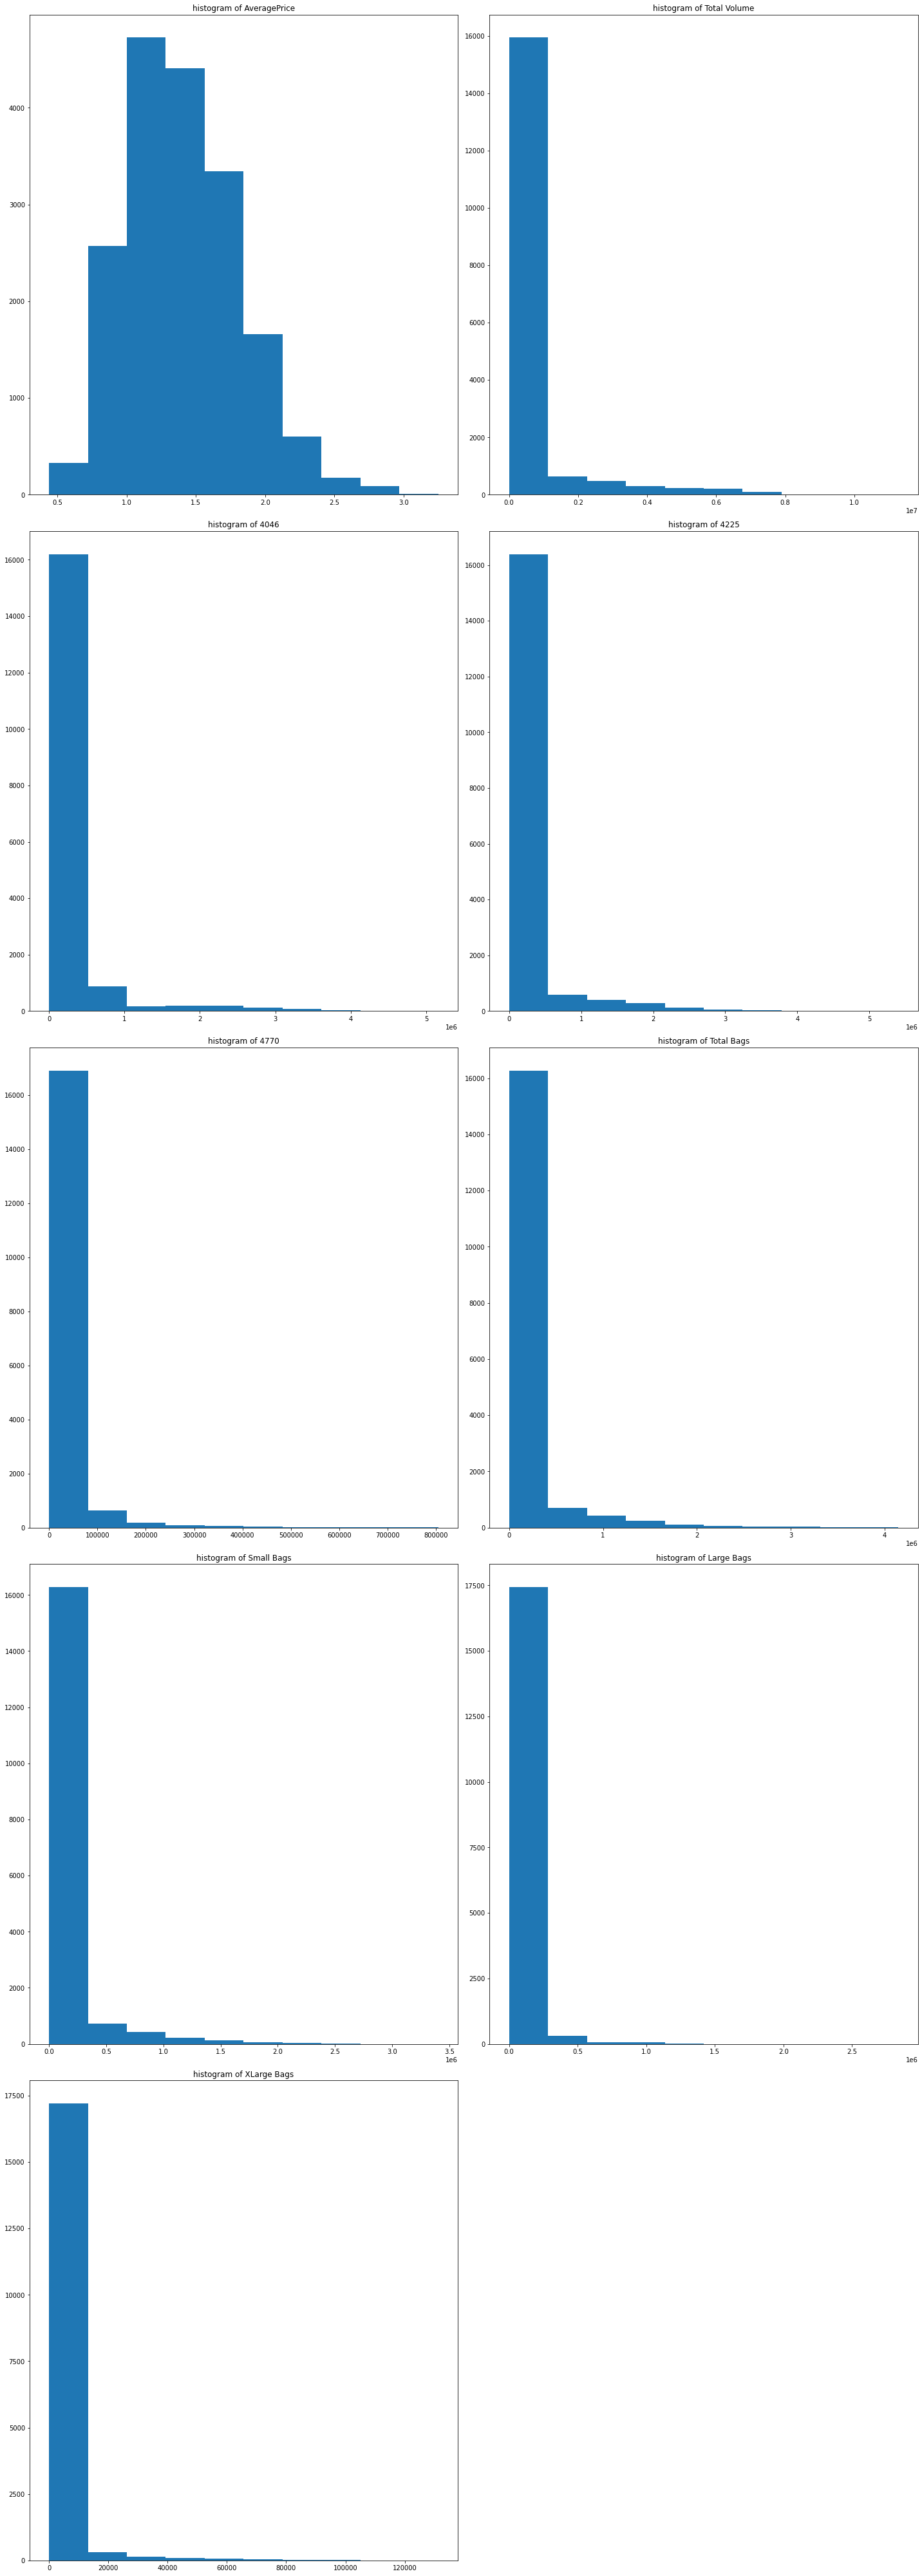

In [18]:
fig = plt.figure(figsize=(20,100))

for i, col in enumerate(numeric_columns):
  plt.subplot(len(numeric_columns), 2, i+1)
  plt.hist(df[col])
  plt.title('histogram of {}'.format(col))

plt.tight_layout()
plt.show()

In [0]:
categorical_columns = ['type', 'year', 'Month', 'new_region']

In [20]:
df.columns

Index(['Unnamed: 0', 'Date', 'AveragePrice', 'Total Volume', '4046', '4225',
       '4770', 'Total Bags', 'Small Bags', 'Large Bags', 'XLarge Bags', 'type',
       'year', 'region', 'Month', 'new_region'],
      dtype='object')

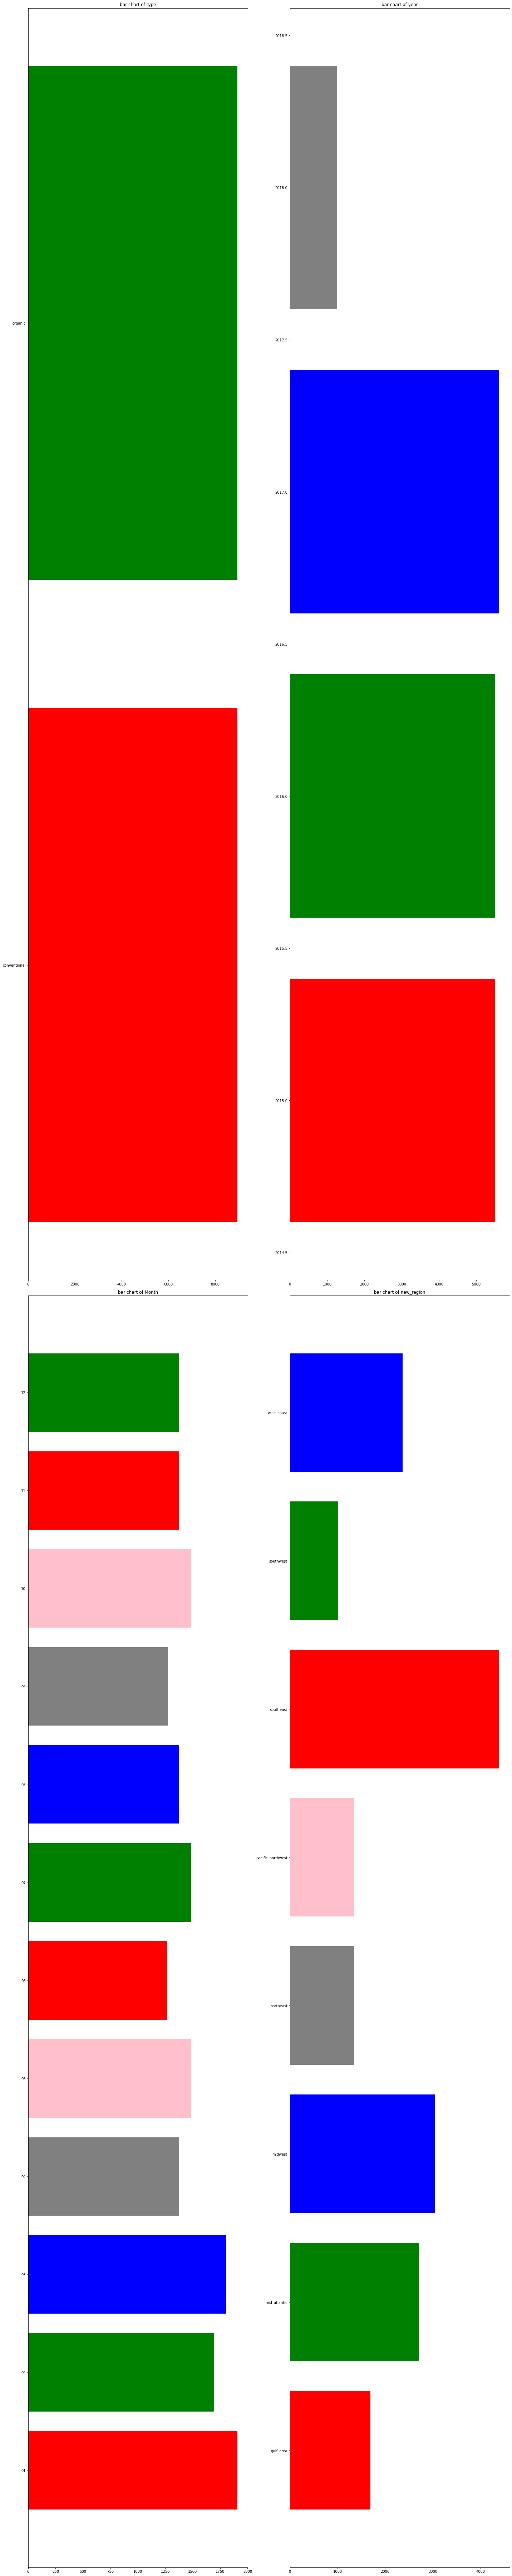

In [21]:
fig = plt.figure(figsize=(20,200))

for i, col in enumerate(categorical_columns):
  plt.subplot(len(categorical_columns), 2, i+1)
  plt.barh(df.groupby(col)[col].count().index, 
          df.groupby(col)[col].count(), 
          color=["red","green","blue","grey","pink"])
  plt.title('bar chart of {}'.format(col))

plt.tight_layout()
plt.show()

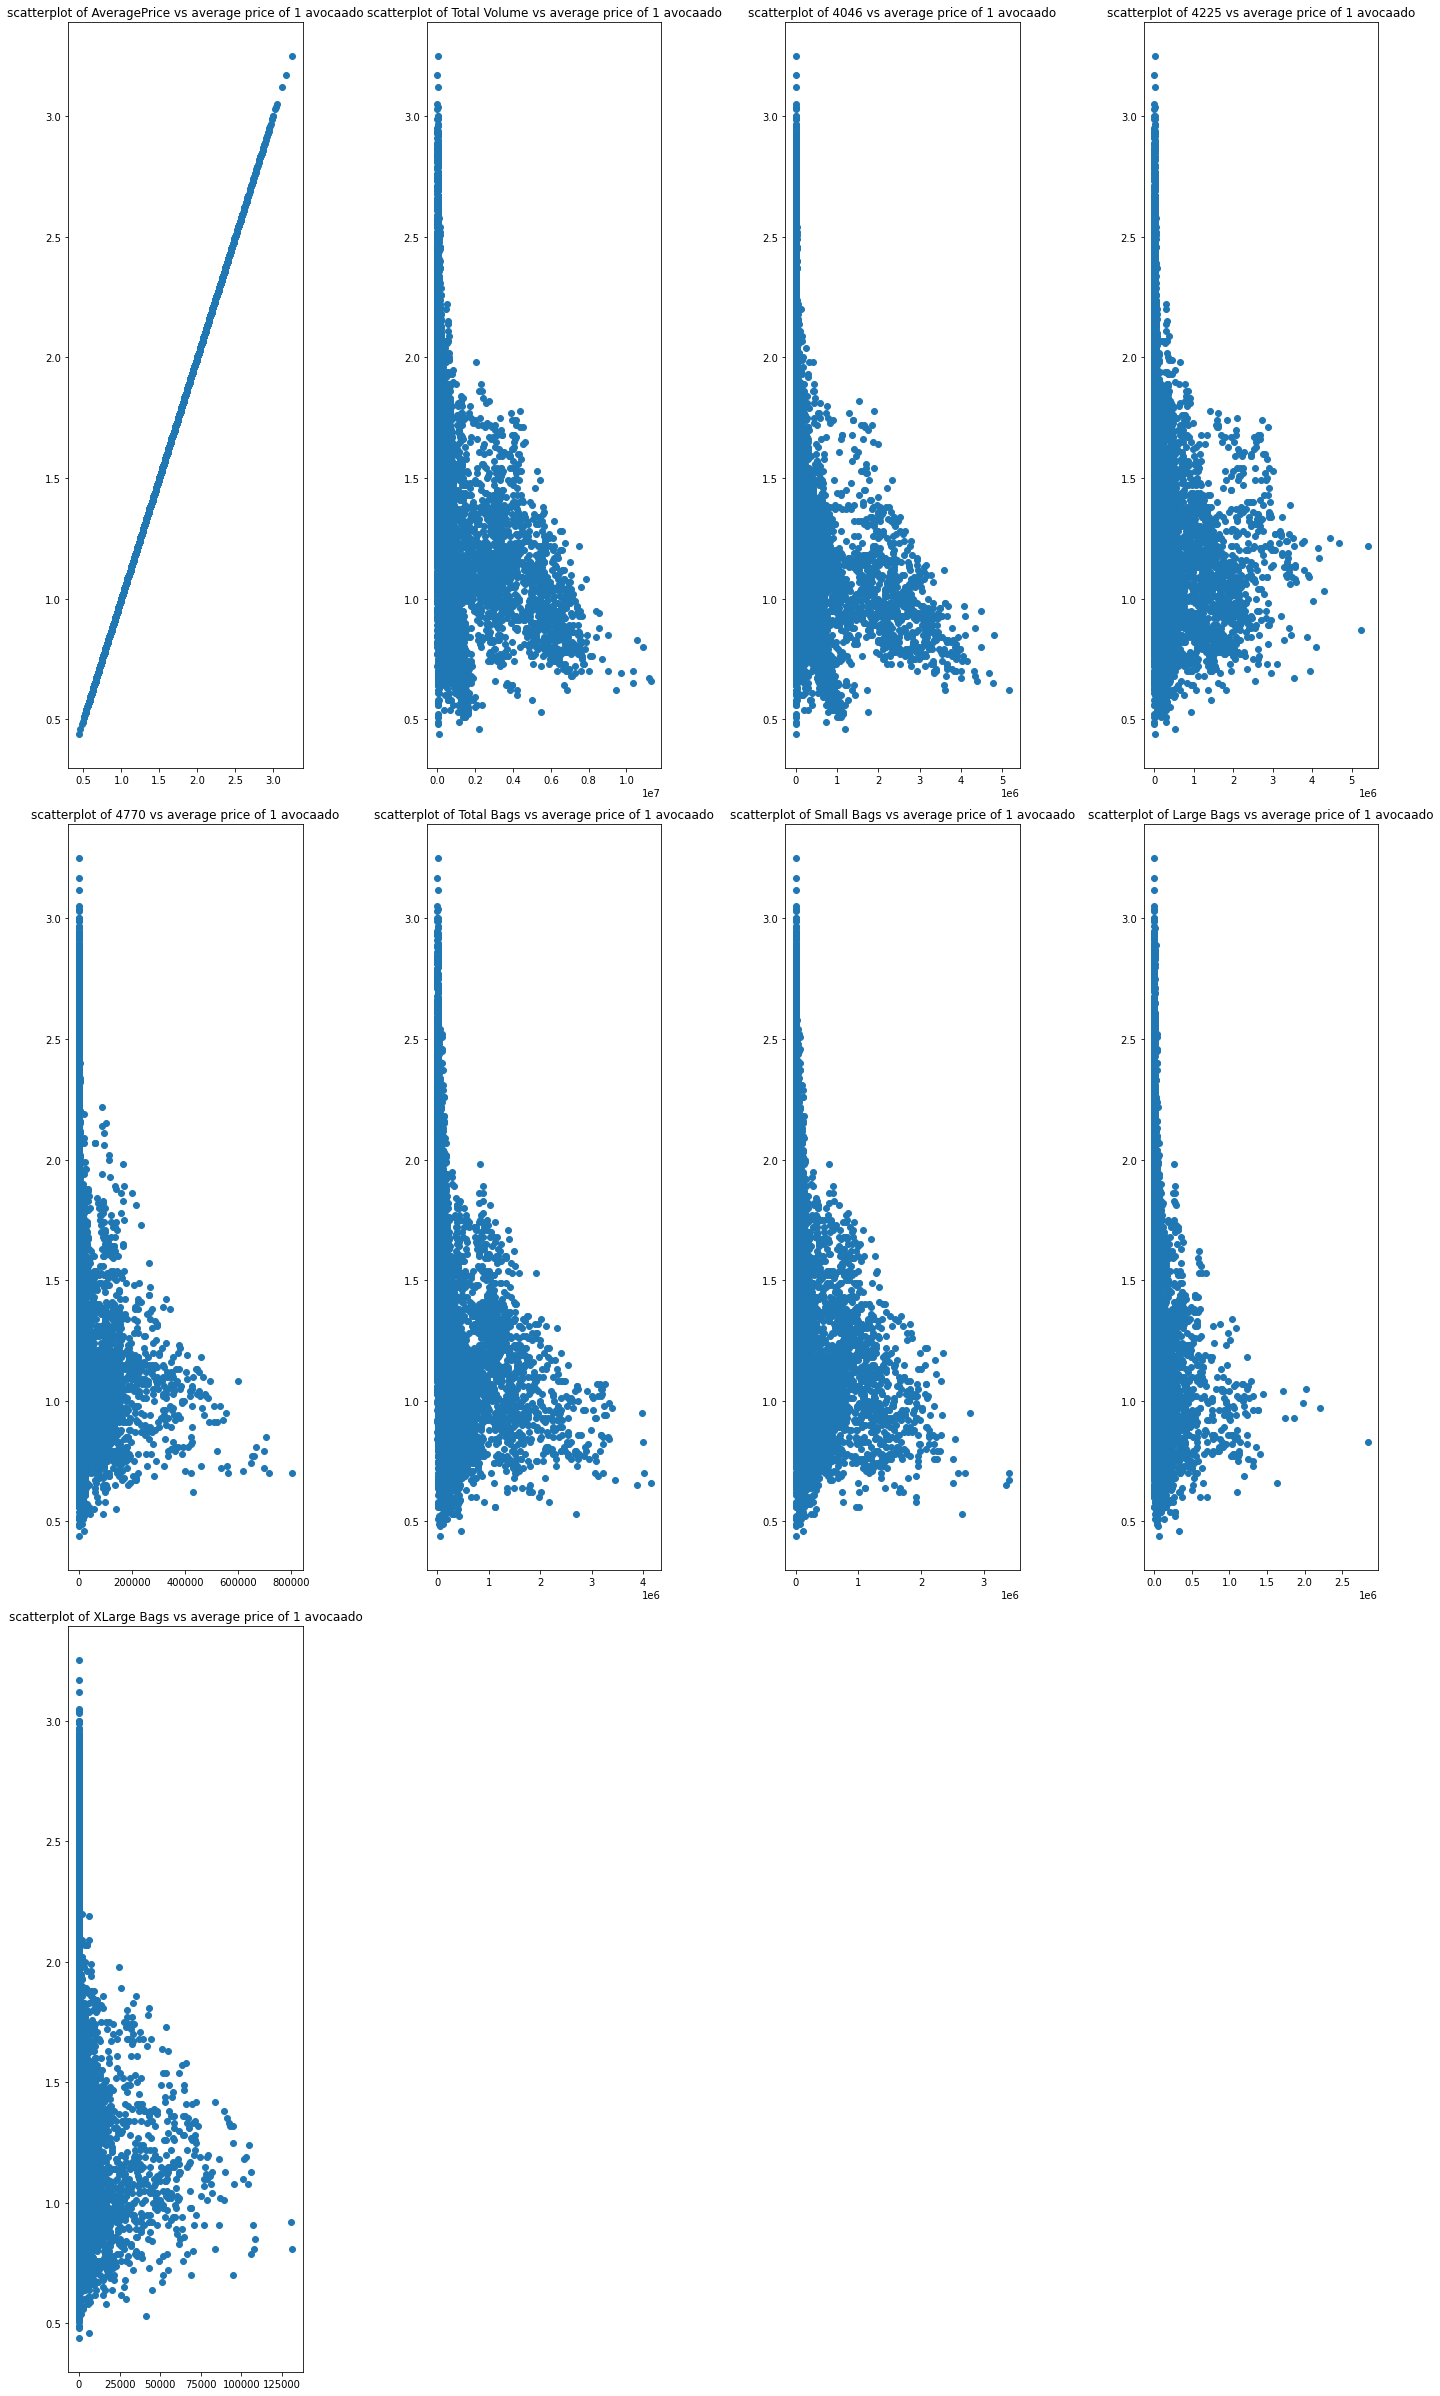

In [22]:
#on to creating scatterplots for the numeric, continuous features. 
fig = plt.figure(figsize=(20,100))

for i, col in enumerate(numeric_columns):
  plt.subplot(len(numeric_columns), 4, i+1)
  plt.scatter(df[col], df['AveragePrice'])
  plt.title('scatterplot of {} vs average price of 1 avocaado'.format(col))

plt.tight_layout()
plt.show()

In [23]:
df_numeric = df[numeric_columns]
df_numeric.corr()

,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags
AveragePrice,1.000000,-0.343982,-0.342105,-0.267643,-0.241213,-0.307685,-0.296151,-0.248909,-0.154424
Total Volume,-0.343982,1.000000,0.895002,0.872547,0.649072,0.924980,0.920763,0.668446,0.538396
4046,-0.342105,0.895002,1.000000,0.603442,0.509280,0.776373,0.761604,0.589649,0.436249
4225,-0.267643,0.872547,0.603442,1.000000,0.623368,0.754345,0.782892,0.466107,0.449903
4770,-0.241213,0.649072,0.509280,0.623368,1.000000,0.553417,0.566304,0.343136,0.587963
Total Bags,-0.307685,0.924980,0.776373,0.754345,0.553417,1.000000,0.969591,0.787834,0.555153
Small Bags,-0.296151,0.920763,0.761604,0.782892,0.566304,0.969591,1.000000,0.613817,0.587470
Large Bags,-0.248909,0.668446,0.589649,0.466107,0.343136,0.787834,0.613817,1.000000,0.267308
XLarge Bags,-0.154424,0.538396,0.436249,0.449903,0.587963,0.555153,0.587470,0.267308,1.000000


In [0]:
df_categorical = df[categorical_columns]

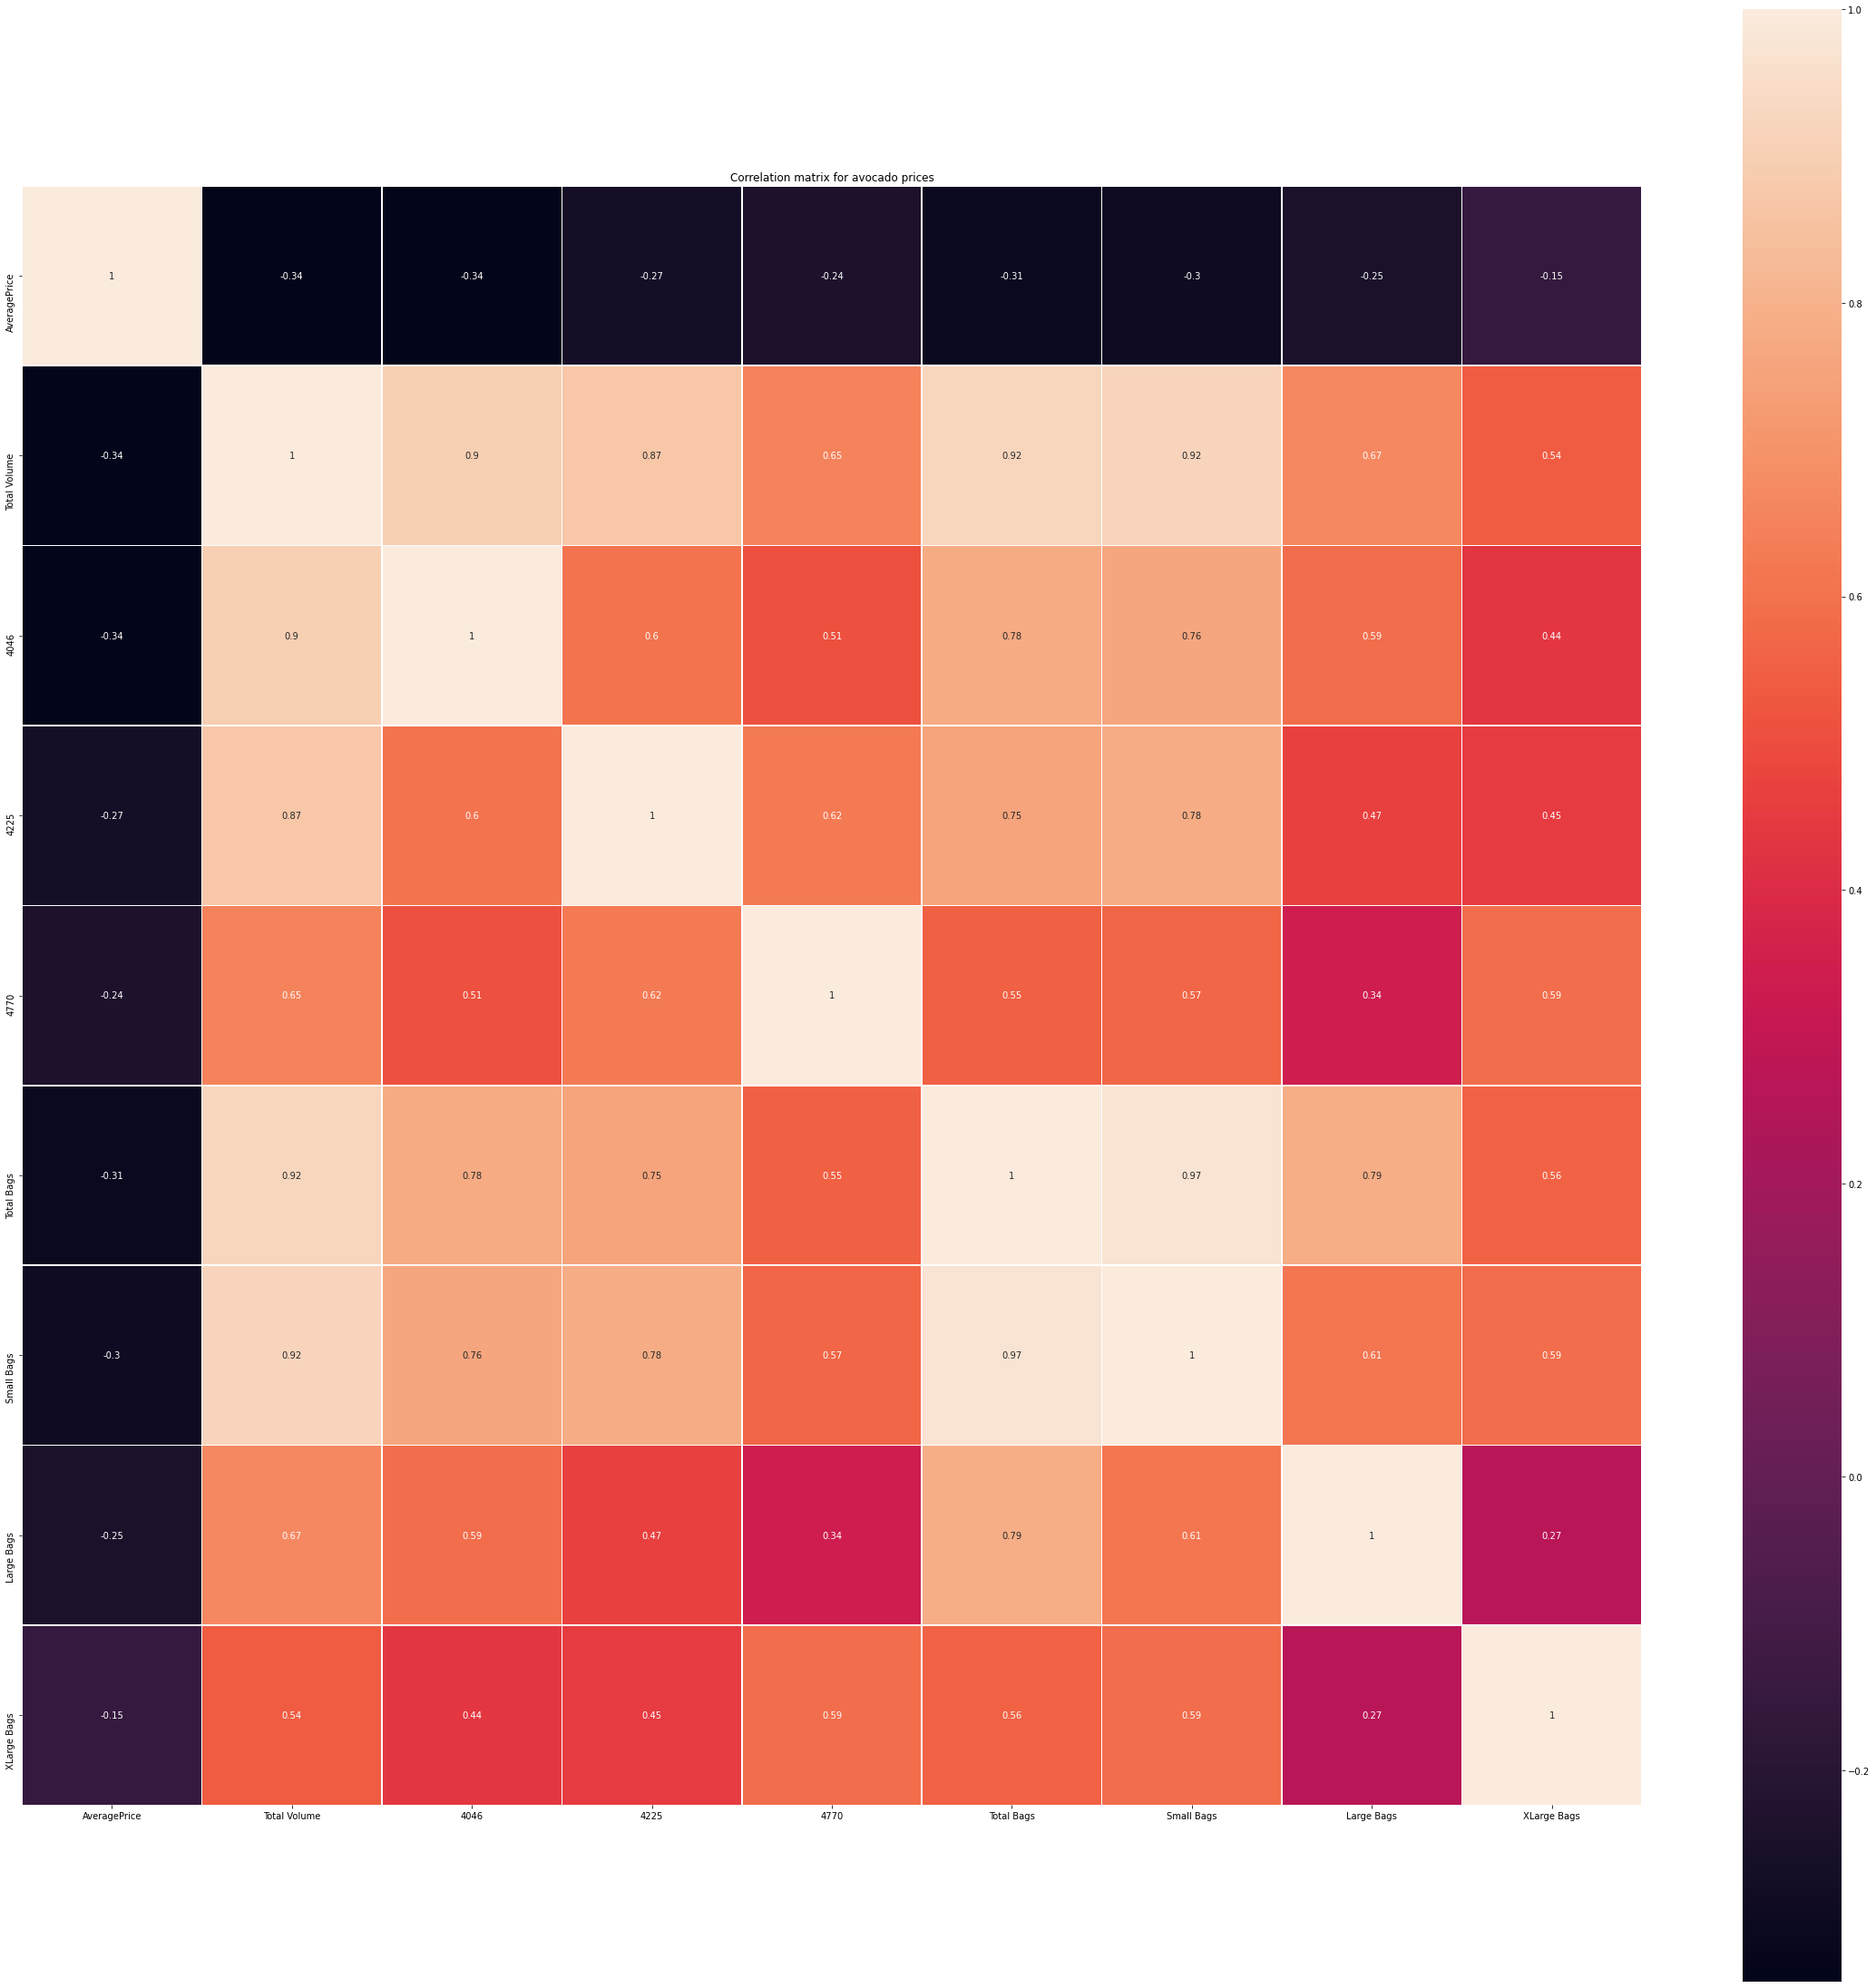

In [25]:
import seaborn as sns
coormat = df_numeric.corr()

plt.figure(figsize=(40,40))
plt.title('Correlation matrix for avocado prices')

sns.heatmap(coormat, square=True, annot=True, linewidth= .5)

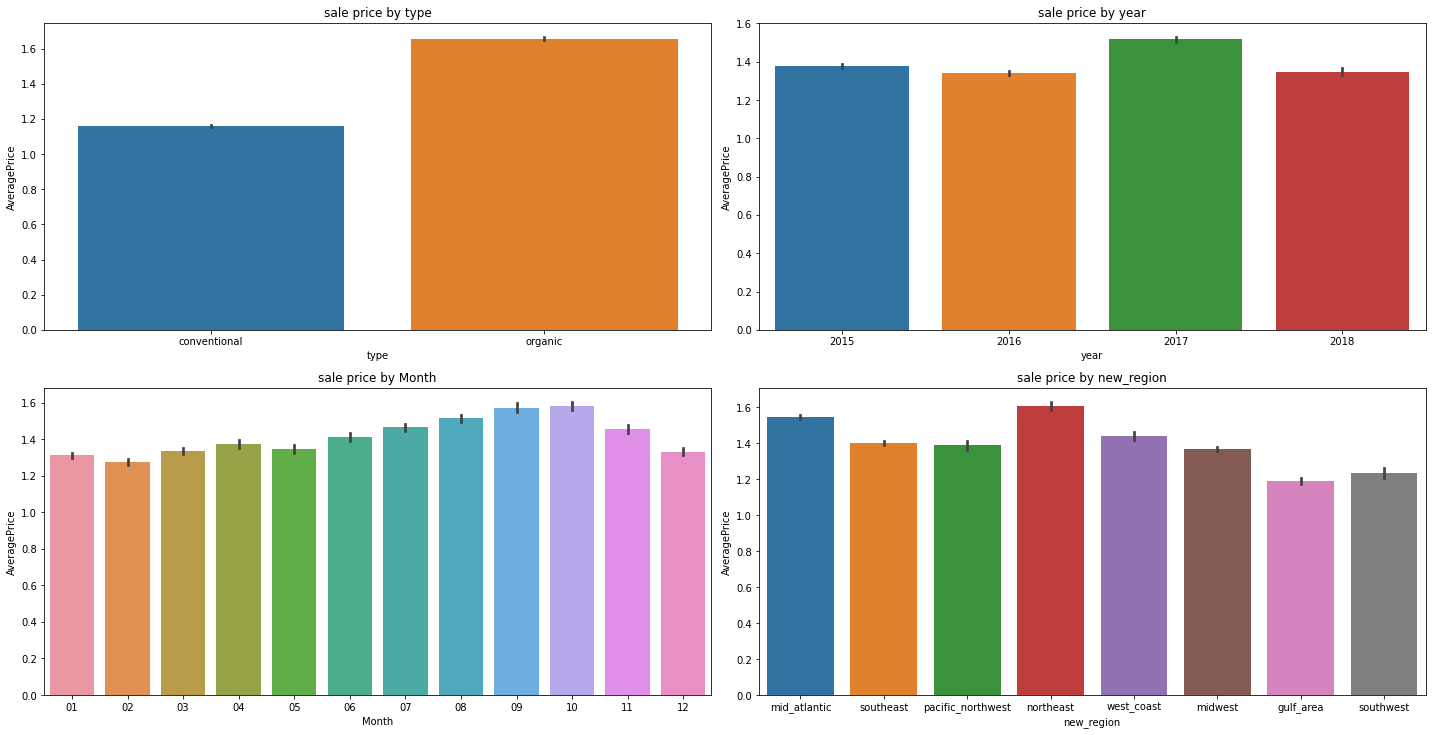

In [26]:
fig = plt.figure(figsize=(20,20))

for i, col in enumerate(categorical_columns):
  plt.subplot(len(categorical_columns), 2, i+1)
  sns.barplot(df[col], df['AveragePrice'])
  plt.title('sale price by {}'.format(col))

plt.tight_layout()
plt.show()

## Feature Engineering
To start the process of feature selection, I am going to begin creating dummies for the categorical variables.

In [27]:
dummy_data = pd.get_dummies(df_categorical.astype(str), drop_first=True)
dummy_data.head()

,type_organic,year_2016,year_2017,year_2018,Month_02,Month_03,Month_04,Month_05,Month_06,Month_07,Month_08,Month_09,Month_10,Month_11,Month_12,new_region_mid_atlantic,new_region_midwest,new_region_northeast,new_region_pacific_northwest,new_region_southeast,new_region_southwest,new_region_west_coast
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0


In [0]:
numeric_and_dummies = pd.concat([df_numeric, dummy_data], axis=1)

In [64]:
#on to looking for the appropriate features...
corr_w_dummies = numeric_and_dummies.corr()
corr_w_dummies['AveragePrice'].sort_values()

Total Volume                   -0.343982
4046                           -0.342105
Total Bags                     -0.307685
Small Bags                     -0.296151
4225                           -0.267643
Large Bags                     -0.248909
4770                           -0.241213
XLarge Bags                    -0.154424
year_2016                      -0.111437
Month_02                       -0.105318
new_region_southwest           -0.104548
Month_03                       -0.060901
Month_12                       -0.053619
Month_05                       -0.044079
new_region_midwest             -0.043395
year_2018                      -0.040577
Month_04                       -0.022301
new_region_pacific_northwest   -0.013510
new_region_southeast           -0.011510
Month_06                        0.001848
new_region_west_coast           0.032409
Month_11                        0.035087
Month_07                        0.042494
Month_08                        0.076503
volume_organic  

In [0]:
#for the features I will be selecting type_organic, total volume and 4046. The reason why I am not selecting total bags and small bags is because these are likely to
#be correlated with one another and be correlated to the total volume as well. 

In [0]:
#scaling and normalizing the data...
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
#X = numeric_and_dummies.loc[:, numeric_and_dummies.columns != 'AveragePrice']
#X = StandardScaler().fit_transform(X)
#sklearn_pca = PCA(n_components=1)
#numeric_and_dummies["pca_1"] = sklearn_pca.fit_transform(X)
#standardize and normalize

In [0]:
numeric_and_dummies.loc[:, numeric_and_dummies.columns != 'AveragePrice'] = StandardScaler().fit_transform(numeric_and_dummies.loc[:, numeric_and_dummies.columns != 'AveragePrice'])
#standardizing the values for processing.

In [33]:
numeric_and_dummies.head()

,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type_organic,year_2016,year_2017,year_2018,Month_02,Month_03,Month_04,Month_05,Month_06,Month_07,Month_08,Month_09,Month_10,Month_11,Month_12,new_region_mid_atlantic,new_region_midwest,new_region_northeast,new_region_pacific_northwest,new_region_southeast,new_region_southwest,new_region_west_coast
0,1.33,-0.387996,-0.354831,-0.295965,-0.297096,-0.394907,-0.386004,-0.302010,-0.240304,-0.999833,-0.666747,-0.675848,-0.27649,-0.323411,-0.334459,-0.288701,-0.300565,-0.276256,-0.300565,-0.288701,-0.27649,-0.300565,-0.288701,3.465150,2.371474,-0.452313,-0.28574,-0.28574,-0.570151,-0.244586,-0.390132
1,1.35,-0.395640,-0.355535,-0.317683,-0.296887,-0.392689,-0.383118,-0.301973,-0.240304,-0.999833,-0.666747,-0.675848,-0.27649,-0.323411,-0.334459,-0.288701,-0.300565,-0.276256,-0.300565,-0.288701,-0.27649,-0.300565,-0.288701,3.465150,2.371474,-0.452313,-0.28574,-0.28574,-0.570151,-0.244586,-0.390132
2,0.93,-0.343902,-0.355301,-0.174952,-0.295409,-0.396420,-0.388018,-0.301924,-0.240304,-0.999833,-0.666747,-0.675848,-0.27649,-0.323411,-0.334459,-0.288701,-0.300565,-0.276256,-0.300565,-0.288701,-0.27649,-0.300565,-0.288701,3.465150,2.371474,-0.452313,-0.28574,-0.28574,-0.570151,-0.244586,-0.390132
3,1.08,-0.375943,-0.354647,-0.257198,-0.296595,-0.402822,-0.396501,-0.301655,-0.240304,-0.999833,-0.666747,-0.675848,-0.27649,-0.323411,-0.334459,-0.288701,-0.300565,-0.276256,-0.300565,-0.288701,-0.27649,-0.300565,-0.288701,3.465150,2.371474,-0.452313,-0.28574,-0.28574,-0.570151,-0.244586,-0.390132
4,1.28,-0.398775,-0.355016,-0.319454,-0.296530,-0.401800,-0.395393,-0.301094,-0.240304,-0.999833,-0.666747,-0.675848,-0.27649,-0.323411,-0.334459,-0.288701,-0.300565,-0.276256,-0.300565,-0.288701,-0.27649,-0.300565,3.463787,-0.288588,2.371474,-0.452313,-0.28574,-0.28574,-0.570151,-0.244586,-0.390132


In [34]:
Y = numeric_and_dummies['AveragePrice']
X = numeric_and_dummies[['type_organic', 'Total Volume', '4046']]

lrm = linear_model.LinearRegression()


lrm.fit(X, Y)


print('\nCoefficients: \n', lrm.coef_)
print('\nIntercept: \n', lrm.intercept_)


Coefficients: 
 [ 0.23322602  0.04543505 -0.09785055]

Intercept: 
 1.407619340070348


In [35]:
import statsmodels.api as sm


X = sm.add_constant(X)

results = sm.OLS(Y, X).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           AveragePrice   R-squared:                       0.399
Model:                            OLS   Adj. R-squared:                  0.399
Method:                 Least Squares   F-statistic:                     3957.
Date:                Tue, 05 May 2020   Prob (F-statistic):               0.00
Time:                        19:20:22   Log-Likelihood:                -4637.5
No. Observations:               17911   AIC:                             9283.
Df Residuals:                   17907   BIC:                             9314.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            1.4076      0.002    600.879      0.000       1.403       1.412
type_organic     0.2332      0.003     90.397      0.000       0.228       0.238
Total Volume     0.0454      0.005      8.378      0.000       0.035       0.056
4046            -0.0979      0.005    -18.599      0.000      -0.108      -0.088
==============================================================================
Omnibus:                      988.507   Durbin-Watson:                   0.315
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1594.751
Skew:                           0.460   Prob(JB):                         0.00
Kurtosis:                       4.136   Cond. No.                         4.59
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

print("Training set obs: {}".format(X_train.shape[0]))
print("Test set obs: {}".format(X_test.shape[0]))

Training set obs: 14328
Test set obs: 3583


In [37]:
X_train = sm.add_constant(X_train)
results = sm.OLS(y_train, X_train).fit()


results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           AveragePrice   R-squared:                       0.400
Model:                            OLS   Adj. R-squared:                  0.400
Method:                 Least Squares   F-statistic:                     3184.
Date:                Tue, 05 May 2020   Prob (F-statistic):               0.00
Time:                        19:20:22   Log-Likelihood:                -3740.9
No. Observations:               14328   AIC:                             7490.
Df Residuals:                   14324   BIC:                             7520.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            1.4104      0.003    537.302      0.000       1.405       1.416
type_organic     0.2343      0.003     80.999      0.000       0.229       0.240
Total Volume     0.0478      0.006      7.977      0.000       0.036       0.060
4046            -0.1000      0.006    -17.247      0.000      -0.111      -0.089
==============================================================================
Omnibus:                      746.311   Durbin-Watson:                   1.976
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1185.841
Skew:                           0.444   Prob(JB):                    3.15e-258
Kurtosis:                       4.094   Cond. No.                         4.58
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [0]:
X_test = sm.add_constant(X_test)

Y_pred = results.predict(X_test)

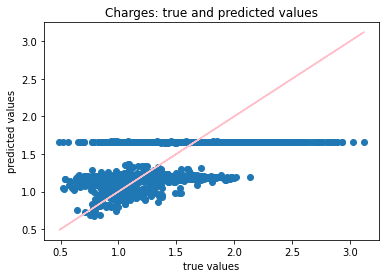

Mean absolute error: 0.23983195410041122
Mean squared error: 0.09660921366401531
Root mean squared error: 0.31082022724400565
Mean absolute percentage error: 18.61607641240454


In [39]:
plt.scatter(y_test, Y_pred)
plt.plot(y_test, y_test, color = 'pink')
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Charges: true and predicted values")
plt.show()

print("Mean absolute error: {}".format(mean_absolute_error(y_test, Y_pred)))
print("Mean squared error: {}".format(mse(y_test, Y_pred)))
print("Root mean squared error: {}".format(rmse(y_test, Y_pred)))
print("Mean absolute percentage error: {}".format(np.mean(np.abs((y_test - Y_pred) / y_test)) * 100))
#while the model doesn't appear to be doing a good job at predicting values, it is generally better with the lower values.

As shown in the above, the r squared and adjusted r squared values are low telling us that there is room for improvement and this one is likely to underfit. However, the p-value of the f-statistic is 0 telling us that what information we do have so far is valuable. In order to lessen the amount of underfitting, I am going to play around with the features to get a more accurate picture.

In [40]:
numeric_and_dummies['volume_organic'] = numeric_and_dummies['Total Volume'] * numeric_and_dummies['type_organic']

Y = numeric_and_dummies['AveragePrice']
X = numeric_and_dummies[['type_organic', 'Total Volume', '4046', 'volume_organic', 'new_region_mid_atlantic', 'new_region_northeast', 'new_region_west_coast', 'new_region_southeast', 'new_region_pacific_northwest', 'new_region_midwest', 'new_region_southwest']]

lrm = linear_model.LinearRegression()


lrm.fit(X, Y)


print('\nCoefficients: \n', lrm.coef_)
print('\nIntercept: \n', lrm.intercept_)


Coefficients: 
 [-0.04157562 -0.66127238 -0.04329715 -0.66118873  0.10526249  0.0985202
  0.08783459  0.06713067  0.03747945  0.04950477  0.00106596]

Intercept: 
 1.132881258009286


In [41]:
import statsmodels.api as sm


X = sm.add_constant(X)

results = sm.OLS(Y, X).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           AveragePrice   R-squared:                       0.470
Model:                            OLS   Adj. R-squared:                  0.470
Method:                 Least Squares   F-statistic:                     1446.
Date:                Tue, 05 May 2020   Prob (F-statistic):               0.00
Time:                        19:20:23   Log-Likelihood:                -3498.7
No. Observations:               17911   AIC:                             7021.
Df Residuals:                   17899   BIC:                             7115.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                            1.1329      0.016     70.123      0.000       1.101       1.165
type_organic                    -0.0416      0.016     -2.556      0.011      -0.073      -0.010
Total Volume                    -0.6613      0.039    -16.997      0.000      -0.738      -0.585
4046                            -0.0433      0.005     -8.255      0.000      -0.054      -0.033
volume_organic                  -0.6612      0.039    -17.165      0.000      -0.737      -0.586
new_region_mid_atlantic          0.1053      0.003     30.739      0.000       0.099       0.112
new_region_northeast             0.0985      0.003     33.158      0.000       0.093       0.104
new_region_west_coast            0.0878      0.003     27.519      0.000       0.082       0.094
new_region_southeast             0.0671      0.004     17.802      0.000       0.060       0.075
new_region_pacific_northwest     0.0375      0.003     12.832      0.000       0.032       0.043
new_region_midwest               0.0495      0.003     14.297      0.000       0.043       0.056
new_region_southwest             0.0011      0.003      0.390      0.697      -0.004       0.006
==============================================================================
Omnibus:                     1344.711   Durbin-Watson:                   0.338
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2539.986
Skew:                           0.533   Prob(JB):                         0.00
Kurtosis:                       4.506   Cond. No.                         46.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The above selected features appear to do a better job at predicting the outcome. While the f-statistic is lower for this one, the adjusted r squared, aic, and bic tell us that the latter model is more favorable.

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

print("Training set obs: {}".format(X_train.shape[0]))
print("Test set obs: {}".format(X_test.shape[0]))

Training set obs: 14328
Test set obs: 3583


In [43]:
X_train = sm.add_constant(X_train)
results = sm.OLS(y_train, X_train).fit()


results.summary()

#this model also performs better on the training set as seen below...

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           AveragePrice   R-squared:                       0.472
Model:                            OLS   Adj. R-squared:                  0.471
Method:                 Least Squares   F-statistic:                     1162.
Date:                Tue, 05 May 2020   Prob (F-statistic):               0.00
Time:                        19:20:23   Log-Likelihood:                -2830.6
No. Observations:               14328   AIC:                             5685.
Df Residuals:                   14316   BIC:                             5776.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                            1.1312      0.018     61.634      0.000       1.095       1.167
type_organic                    -0.0458      0.018     -2.478      0.013      -0.082      -0.010
Total Volume                    -0.6717      0.044    -15.198      0.000      -0.758      -0.585
4046                            -0.0437      0.006     -7.536      0.000      -0.055      -0.032
volume_organic                  -0.6717      0.044    -15.347      0.000      -0.757      -0.586
new_region_mid_atlantic          0.1051      0.004     27.389      0.000       0.098       0.113
new_region_northeast             0.0993      0.003     29.889      0.000       0.093       0.106
new_region_west_coast            0.0889      0.004     24.730      0.000       0.082       0.096
new_region_southeast             0.0658      0.004     15.584      0.000       0.058       0.074
new_region_pacific_northwest     0.0400      0.003     12.203      0.000       0.034       0.046
new_region_midwest               0.0489      0.004     12.577      0.000       0.041       0.057
new_region_southwest             0.0019      0.003      0.635      0.525      -0.004       0.008
==============================================================================
Omnibus:                     1029.447   Durbin-Watson:                   1.976
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1929.893
Skew:                           0.516   Prob(JB):                         0.00
Kurtosis:                       4.472   Cond. No.                         47.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [0]:
X_test = sm.add_constant(X_test)

Y_pred = results.predict(X_test)

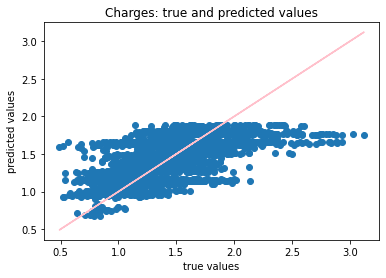

Mean absolute error: 0.22239648483209773
Mean squared error: 0.08509520416780661
Root mean squared error: 0.2917108228499701
Mean absolute percentage error: 17.132319309217923


In [45]:
plt.scatter(y_test, Y_pred)
plt.plot(y_test, y_test, color = 'pink')
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Charges: true and predicted values")
plt.show()

print("Mean absolute error: {}".format(mean_absolute_error(y_test, Y_pred)))
print("Mean squared error: {}".format(mse(y_test, Y_pred)))
print("Root mean squared error: {}".format(rmse(y_test, Y_pred)))
print("Mean absolute percentage error: {}".format(np.mean(np.abs((y_test - Y_pred) / y_test)) * 100))
#based on the given figures and the graph below, this model is better at predicting values. 

In [46]:
alphas = [np.power(10.0,p) for p in np.arange(-10,40,1)]
ridge_reg = RidgeCV(alphas= alphas, cv=5)
ridge_reg.fit(X_train, y_train)
y_train_predictions = ridge_reg.predict(X_train)
y_test_predictions = ridge_reg.predict(X_test)

print("Best alpha value is: {}".format(ridge_reg.alpha_))
print("R-squared of the model in training set is: {}".format(ridge_reg.score(X_train, y_train)))

print("R-squared of the model in test set is: {}".format(ridge_reg.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_test_predictions)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_test_predictions)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_test_predictions)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_test_predictions) / y_test)) * 100))
#not much has changed here after applying ridge regression as seen below.

Best alpha value is: 0.1
R-squared of the model in training set is: 0.47167557272157945
R-squared of the model in test set is: 0.4638507416892069
Mean absolute error of the prediction is: 0.22239054684512827
Mean squared error of the prediction is: 0.085094223301642
Root mean squared error of the prediction is: 0.29170914161479755
Mean absolute percentage error of the prediction is: 17.13187030377068


In [47]:
lasso_reg = LassoCV(alphas=alphas, cv=5)

lasso_reg.fit(X_train, y_train)
y_train_predictions =  lasso_reg.predict(X_train)
y_test_predictions = lasso_reg.predict(X_test)

print("Best alpha value is: {}".format(lasso_reg.alpha_))
print("R-squared of the model in training set is: {}".format(lasso_reg.score(X_train, y_train)))

print("R-squared of the model in test set is: {}".format(lasso_reg.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_test_predictions)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_test_predictions)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_test_predictions)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_test_predictions) / y_test)) * 100))
#not much has changed over here after applying lasso regression.

Best alpha value is: 1e-06
R-squared of the model in training set is: 0.471658423771096
R-squared of the model in test set is: 0.46388866946731366
Mean absolute error of the prediction is: 0.22233481192172858
Mean squared error of the prediction is: 0.08508820364429934
Root mean squared error of the prediction is: 0.2916988235223093
Mean absolute percentage error of the prediction is: 17.12735150210189


In [48]:
elasticnet_reg = ElasticNetCV(alphas=alphas, cv=5)

elasticnet_reg.fit(X_train, y_train)
y_train_predictions =  elasticnet_reg.predict(X_train)
y_test_predictions = elasticnet_reg.predict(X_test)

print("Best alpha value is: {}".format(elasticnet_reg.alpha_))
print("R-squared of the model in training set is: {}".format(elasticnet_reg.score(X_train, y_train)))

print("R-squared of the model in test set is: {}".format(elasticnet_reg.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_test_predictions)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_test_predictions)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_test_predictions)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_test_predictions) / y_test)) * 100))

Best alpha value is: 1e-06
R-squared of the model in training set is: 0.47165860062943155
R-squared of the model in test set is: 0.4638884343940932
Mean absolute error of the prediction is: 0.2223351157592871
Mean squared error of the prediction is: 0.08508824095363589
Root mean squared error of the prediction is: 0.2916988874741141
Mean absolute percentage error of the prediction is: 17.127380371874967


As shown in the above, the regressions did not return us more desirable figures indicating that there isn't much overfitting going on to begin with. Hence, we can do without it. 

## Next Model: K- Nearest Neighbors
I am now going to conduct a k-nearest neighbors analysis. This will first begin with gathering the features in their raw form and then normalizing them.

In [0]:
numeric_and_dummies_2 = pd.concat([df_numeric, dummy_data], axis=1)

In [50]:
numeric_and_dummies_2.head()

,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type_organic,year_2016,year_2017,year_2018,Month_02,Month_03,Month_04,Month_05,Month_06,Month_07,Month_08,Month_09,Month_10,Month_11,Month_12,new_region_mid_atlantic,new_region_midwest,new_region_northeast,new_region_pacific_northwest,new_region_southeast,new_region_southwest,new_region_west_coast
0,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0
1,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0
2,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0
3,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0
4,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0


In [0]:
#I am going to add in that additional feature of the volume of organic avocados. 
numeric_and_dummies_2['volume_organic'] = numeric_and_dummies_2['Total Volume'] *numeric_and_dummies_2['type_organic']

In [52]:
#will first normalize the data...
from sklearn import datasets
from sklearn import preprocessing
from sklearn.preprocessing import Normalizer
numeric_and_dummies_2.loc[:, numeric_and_dummies_2.columns != 'AveragePrice'] = preprocessing.normalize(numeric_and_dummies_2.loc[:, numeric_and_dummies_2.columns != 'AveragePrice'])
numeric_and_dummies_2.head()




,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type_organic,year_2016,year_2017,year_2018,Month_02,Month_03,Month_04,Month_05,Month_06,Month_07,Month_08,Month_09,Month_10,Month_11,Month_12,new_region_mid_atlantic,new_region_midwest,new_region_northeast,new_region_pacific_northwest,new_region_southeast,new_region_southwest,new_region_west_coast,volume_organic
0,1.33,0.754816,0.012182,0.639874,0.000566,0.102193,0.101097,0.001096,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000012,0.000012,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.35,0.762221,0.009366,0.620017,0.000810,0.132029,0.130675,0.001354,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000014,0.000014,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.93,0.732870,0.004926,0.676640,0.000809,0.050495,0.049855,0.000639,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000006,0.000006,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.08,0.737001,0.010562,0.671544,0.000677,0.054218,0.052970,0.001248,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000009,0.000009,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.28,0.752386,0.013879,0.646232,0.001117,0.091159,0.088245,0.002914,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000015,0.000000,0.000015,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [53]:
from sklearn import neighbors
knn = neighbors.KNeighborsRegressor(n_neighbors=10)
Y = numeric_and_dummies_2['AveragePrice']
X = numeric_and_dummies_2[['type_organic', 'Total Volume', '4046', 'volume_organic', 'new_region_mid_atlantic', 'new_region_northeast', 'new_region_west_coast', 'new_region_southeast', 'new_region_pacific_northwest', 'new_region_midwest', 'new_region_southwest']]
knn.fit(X,Y)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                    weights='uniform')

In [54]:
from sklearn.model_selection import cross_val_score
score = cross_val_score(knn, X, Y, cv=5)
print("Unweighted Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))


Unweighted Accuracy: -0.04 (+/- 0.51)


In [55]:
knn = neighbors.KNeighborsRegressor(n_neighbors=10, weights='distance')
Y = numeric_and_dummies_2['AveragePrice']
X = numeric_and_dummies_2[['type_organic', 'Total Volume', '4046', 'volume_organic', 'new_region_mid_atlantic', 'new_region_northeast', 'new_region_west_coast', 'new_region_southeast', 'new_region_pacific_northwest', 'new_region_midwest', 'new_region_southwest']]
knn.fit(X,Y)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                    weights='distance')

In [56]:
score = cross_val_score(knn, X, Y, cv=5)
print("Unweighted Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))


Unweighted Accuracy: -0.08 (+/- 0.56)


From the above, we can see that k-nearest neighbors is inn fact not doing a good job at predicting values. It is slightly more accurate after playing around with the neighbors and settling on 10 neighbors, and the results look to be more clear-cut when it is not weighted. 

## On to Random Forest... will gather the numeric features and the dummies once again. 

In [57]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import tree
from sklearn import ensemble

numeric_and_dummies_3 = pd.concat([df_numeric, dummy_data], axis=1)
numeric_and_dummies_3['volume_organic'] = numeric_and_dummies_3['Total Volume'] * numeric_and_dummies_3['type_organic']

X = numeric_and_dummies_3[['type_organic', 'Total Volume', '4046', 'volume_organic', 'new_region_mid_atlantic', 'new_region_northeast', 'new_region_west_coast', 'new_region_southeast', 'new_region_pacific_northwest', 'new_region_midwest', 'new_region_southwest']]
Y = numeric_and_dummies_3['AveragePrice']
rfc = ensemble.RandomForestRegressor()
cross_val_score(rfc, X, Y, cv=5)
#As seen below, according to the cross validation score, this isn't giving us good accuracy...in the next random forest classifier I will be playing around with X.

array([-0.88547107,  0.15246984,  0.42821976, -0.06112202, -0.13311966])

In [58]:
X = numeric_and_dummies_3.drop('AveragePrice', 1)
Y = numeric_and_dummies_3['AveragePrice']
cross_val_score(rfc, X, Y, cv=5)
#Looks like the accuracy did increase when including all the features as seen below.

array([-0.12017009,  0.34113876,  0.66306711,  0.2764195 , -0.03340637])

## SVM
For support vector machines, we will first begin by normalizing the data as this is a general assumption for SVM. I will be using the second dataframe of the features and dummies as this is already normalized. 

In [59]:
numeric_and_dummies_2.head()

,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type_organic,year_2016,year_2017,year_2018,Month_02,Month_03,Month_04,Month_05,Month_06,Month_07,Month_08,Month_09,Month_10,Month_11,Month_12,new_region_mid_atlantic,new_region_midwest,new_region_northeast,new_region_pacific_northwest,new_region_southeast,new_region_southwest,new_region_west_coast,volume_organic
0,1.33,0.754816,0.012182,0.639874,0.000566,0.102193,0.101097,0.001096,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000012,0.000012,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.35,0.762221,0.009366,0.620017,0.000810,0.132029,0.130675,0.001354,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000014,0.000014,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.93,0.732870,0.004926,0.676640,0.000809,0.050495,0.049855,0.000639,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000006,0.000006,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.08,0.737001,0.010562,0.671544,0.000677,0.054218,0.052970,0.001248,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000009,0.000009,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.28,0.752386,0.013879,0.646232,0.001117,0.091159,0.088245,0.002914,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000015,0.000000,0.000015,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
from sklearn.svm import SVR
svr = SVR()

Y = numeric_and_dummies_2['AveragePrice']
X = numeric_and_dummies_2[['type_organic', 'Total Volume', '4046', 'volume_organic', 'new_region_mid_atlantic', 'new_region_northeast', 'new_region_west_coast', 'new_region_southeast', 'new_region_pacific_northwest', 'new_region_midwest', 'new_region_southwest']]

In [61]:
cross_val_score(svr, X, Y, cv=5)
#Again...the accuracy isn't looking good here. Next, I will be including all possible features.

array([-0.35897826,  0.0739327 ,  0.36405986, -0.03376997, -0.00370506])

In [62]:
X = numeric_and_dummies_2.drop('AveragePrice', 1)
Y = numeric_and_dummies_2['AveragePrice']
cross_val_score(svr, X, Y, cv=5 )

array([-0.02913471,  0.17454361,  0.48423847,  0.25607197,  0.00208014])

## Gradient Boosting
I will now be using gradient boosting to improve on the previous models created to see if this offers a chance at helping produce a strong lerner.

In [63]:
X = numeric_and_dummies_3.drop('AveragePrice', 1)
Y = numeric_and_dummies_3['AveragePrice']

preds = pd.DataFrame()
labels = []

for m in range(0, 101):
    
    
    decision_tree = tree.DecisionTreeRegressor(max_depth=2)
    decision_tree.fit(X,Y)
    
    
    pred = decision_tree.predict(X)
    preds['pred{}'.format(m)] = pred
    
    
    Y = Y - pred


predicted = preds.sum(axis=1)

print('Overall R^2:')
print(np.corrcoef(numeric_and_dummies_3['AveragePrice'], predicted)[0, 1])

Overall R^2:
0.8971427674363472


## Conclusion
As we have seen from the various supervised models, none in particular necessarily did a good job at prediction the darget variable. If we look at the models without any gradient boosting, the strongest performer was the linear regression model, which was able to explain roughly 46% of the target variables accurately. However, we have been able to create a strong-performing model with gradient boosting with simple decision trees of no more than 4 leaves. As we can see in the above, the R^2 returned was almost 90%, which is much stronger than any of the examples we have tested prior. 